# Question 6: Question de recherche


In [18]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from scipy import stats
import random
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')


In [19]:
data_dir = Path("data") 

universities = [
    'Caltech36.gml',
    'Haverford76.gml',
    'MIT8.gml',
    'Johns Hopkins55.gml'
]

MIN_COMMUNITY_SIZE = 10 

In [20]:
import networkx.algorithms.community as nx_comm

#algo 1 : louvain

def get_louvain_communities(G):
    """Retourne un dict {node: community_id} via Louvain"""
    
    comms = nx.community.louvain_communities(G, seed=42)

    partition = {}
    for idx, c in enumerate(comms):
        for node in c: partition[node] = idx
    return partition

#algo 2 : LPA

def fisher_yates(arr):
    """
    Parameters: 
        arr: list
            list of element 
    Return: 
        list: return list arr list shuffled  
    """
    n = len(arr)
    for i in range(n - 1, 0, -1):
        j = random.randint(0, i)
        arr[i], arr[j] = arr[j], arr[i]
    return arr

def lpa(G, max_iter=100):
    """
    Parameters:
        G: Graph 
        max_iter: int (optional)
        
    Return:
        Dict: where the key are the nodes id and the values are the labels  assiated to each node
    """
    nodes = list(G.nodes())
    #étape 1 : attribuer une étiquette unique à chaque noeud du réseau
    labels = {node: i for i, node in enumerate(nodes)}
    
    for iteration in range(max_iter):
        #étape 2 : disposer les noeuds du réseau dans un ordre aléatoire, on utilise l'algo de
        #Fisher Yates pour mélanger l'ID des noeuds aléatoirement
        nodes_shuffled = fisher_yates(nodes.copy())
        has_changed = False
        
        for node in nodes_shuffled:
            #pour chaque noeud du réseau
            neighbors = list(G.neighbors(node))
            if not neighbors:
                continue
            
            #on regarde ses voisins
            neighbor_labels = [labels[nbr] for nbr in neighbors]
            
            #et on cherche l'étiquette qui a la fréquence la + élevée parmi eux
            label_counts = {}
            for l in neighbor_labels:
                label_counts[l] = label_counts.get(l, 0) + 1
            
            if not label_counts: continue #si pas de voisin
            max_freq = max(label_counts.values())
            
            best_labels = [l for l, freq in label_counts.items() if freq == max_freq]
            #on gère aussi le cas où plusieurs étiquettes ont la fréquence la + élevée
            
            new_label = random.choice(best_labels)
            
            if labels[node] != new_label:
                labels[node] = new_label #on attribue cette meilleure étiquette au noeud considéré
                has_changed = True
        
        if not has_changed:
            #on continue tant qu'il existe un nœud avec une étiquette qui a du changer pour avoir
            # la fréquence la plus élevée parmi ses voisins.
            print(f"LPA converged after {iteration+1} iterations.")
            break
            
    return labels

In [22]:
def get_cohort_targets(G):
    """
    fonction pour décider des années qui caractérisent le groupe "Freshman" ou "Senior".
    on vérifie notamment que pour une université donnée, on a une taille de population suffisante
    pour une année récente donnée. Par ex, si 2010 n'a pas assez de population on prend 2009 pour caractériser
    les Freshman.
    """
    years = [G.nodes[n].get('year', 0) for n in G.nodes()]
    # On ne garde que les années >= 2004 car facebook a été lancé pour harvard à ce moment là
    #on ne veut donc pas caractériser de groupe avec des étudiants qui ont graduated avant 2004
    valid_years = [y for y in years if y >= 2004]
    
    if not valid_years: return None, None
    counts = Counter(valid_years)
    sorted_years = sorted(counts.keys(), reverse=True)
    fresh_candidate = sorted_years[0]
    
    if len(sorted_years) > 1:
        next_year = sorted_years[1]
        if counts[fresh_candidate] < 0.2 * counts[next_year]:
            fresh_target = next_year
        else:
            fresh_target = fresh_candidate
    else:
        fresh_target = fresh_candidate
        
    senior_target = fresh_target - 3 #les seniors ont 3 ans de plus que les freshman (on graduate à la fin de la 4e année aux USA)
    return fresh_target, senior_target

def calculate_community_metrics(G, nodes, fresh_target, senior_target):
    """Calcule la "pureté" (Dominance Ratio d'étudiants d'une année majoritaire) d'un groupe 
     et le type de cohorte (freshman/senior/intermediate)"""
    years = [G.nodes[n].get('year', 0) for n in nodes]
    years = [y for y in years if y > 2000] #2000 car on peut accepter quelques vieux étudiants.
    
    if len(years) < 5: return None #il faut au moins 5 années de graduation qui respectent les conditions
    #pour pouvoir calculer le ratio
    
    counts = Counter(years)
    dom_year, count = counts.most_common(1)[0]
    ratio = count / len(years)
    
    c_type = 'Intermediate'
    if dom_year == fresh_target: c_type = 'Freshman'
    elif dom_year == senior_target: c_type = 'Senior'
    
    return {
        'dominant_year': dom_year,
        'dominance_ratio': ratio,
        'type': c_type,
        'size': len(nodes)
    }

In [23]:
results = []
np.random.seed(42)


for univ_file in universities:
    name = univ_file.replace('.gml', '')
    print(f"\nUniversité : {name}")
    
    G = nx.read_gml(data_dir / univ_file)
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
        
    fresh_t, senior_t = get_cohort_targets(G)
    print(f"années considérées comme senior : {senior_t}, comme freshman : {fresh_t}")
    if not fresh_t:
        print("Pas d'années valides.")
        continue    
    algos = {
        'Louvain': get_louvain_communities,
        'LPA': lpa
    }
    
    for algo_name, algo_func in algos.items():
        print(f"Exécution de {algo_name}...")
        
        partition = algo_func(G)
        groups = {}
        for n, c_id in partition.items():
            if c_id not in groups: groups[c_id] = []
            groups[c_id].append(n)
        
        print(f"{len(groups)} communautés trouvées.")
        
        for c_id, nodes in groups.items():
            if len(nodes) < MIN_COMMUNITY_SIZE: continue
            
            met = calculate_community_metrics(G, nodes, fresh_t, senior_t)
            if met:
                met['university'] = name
                met['algorithm'] = algo_name
                met['community_id'] = c_id
                results.append(met)


Université : Caltech36
années considérées comme senior : 2006, comme freshman : 2009
Exécution de Louvain...
9 communautés trouvées.
Exécution de LPA...
LPA converged after 7 iterations.
1 communautés trouvées.

Université : Haverford76
années considérées comme senior : 2006, comme freshman : 2009
Exécution de Louvain...
5 communautés trouvées.
Exécution de LPA...
LPA converged after 17 iterations.
2 communautés trouvées.

Université : MIT8
années considérées comme senior : 2006, comme freshman : 2009
Exécution de Louvain...
12 communautés trouvées.
Exécution de LPA...
LPA converged after 12 iterations.
4 communautés trouvées.

Université : Johns Hopkins55
années considérées comme senior : 2006, comme freshman : 2009
Exécution de Louvain...
9 communautés trouvées.
Exécution de LPA...
5 communautés trouvées.


In [27]:
df = pd.DataFrame(results)
path = Path('outputs/question6')
path.mkdir(parents=True, exist_ok=True)
df.to_csv(path / 'results_final.csv', index=False)

print(df.groupby(['algorithm', 'type'])['dominance_ratio'].mean())

algorithm  type        
LPA        Freshman        0.991474
           Intermediate    0.438494
           Senior          0.234286
Louvain    Freshman        0.930406
           Intermediate    0.431787
           Senior          0.287252
Name: dominance_ratio, dtype: float64


In [28]:
import pandas as pd
from IPython.display import display, HTML

pd.set_option('display.max_rows', None)

type_order = {'Freshman': 0, 'Senior': 1, 'Intermediate': 2}
df['type_rank'] = df['type'].map(type_order)

for univ in df['university'].unique():
    display(HTML(f"<h3 style='background-color:#333; color:white; padding:10px; border-radius:5px;'> Université : {univ}</h3>"))
    
    univ_data = df[df['university'] == univ].copy()
    
    univ_data = univ_data.sort_values(
        by=['algorithm', 'type_rank', 'dominance_ratio'], 
        ascending=[True, True, False]
    )
    
    cols_to_show = ['algorithm', 'community_id', 'type', 'dominance_ratio', 'dominant_year', 'size']
    
    styled_table = (univ_data[cols_to_show].style
                    .format({'dominance_ratio': "{:.1%}"})
                    .set_properties(**{'text-align': 'center'})
                    .set_caption(f"Liste des communautés détectées pour {univ}")
                   )
    
    display(styled_table)


,algorithm,community_id,type,dominance_ratio,dominant_year,size
9,LPA,623,Intermediate,26.8%,2008,762
3,Louvain,3,Freshman,81.2%,2009,17
0,Louvain,0,Senior,35.0%,2006,90
7,Louvain,7,Senior,31.7%,2006,115
1,Louvain,1,Senior,23.6%,2006,88
4,Louvain,4,Intermediate,83.3%,2008,27
2,Louvain,2,Intermediate,32.4%,2008,82
6,Louvain,6,Intermediate,32.4%,2007,122
8,Louvain,8,Intermediate,30.4%,2008,125
5,Louvain,5,Intermediate,28.2%,2008,96


,algorithm,community_id,type,dominance_ratio,dominant_year,size
16,LPA,306,Freshman,100.0%,2009,268
15,LPA,370,Intermediate,27.8%,2008,1178
10,Louvain,0,Freshman,99.3%,2009,293
14,Louvain,4,Senior,37.1%,2006,217
11,Louvain,1,Intermediate,87.0%,2008,314
13,Louvain,3,Intermediate,49.5%,2005,336
12,Louvain,2,Intermediate,48.3%,2007,286


,algorithm,community_id,type,dominance_ratio,dominant_year,size
30,LPA,4872,Intermediate,90.0%,2010,18
29,LPA,445,Intermediate,73.9%,2010,34
28,LPA,1997,Intermediate,19.4%,2008,6347
20,Louvain,3,Freshman,94.7%,2009,958
25,Louvain,9,Senior,28.2%,2006,97
23,Louvain,7,Senior,27.6%,2006,975
24,Louvain,8,Senior,26.3%,2006,366
22,Louvain,5,Intermediate,62.3%,2008,652
18,Louvain,1,Intermediate,37.3%,2004,877
26,Louvain,10,Intermediate,35.8%,2007,802


,algorithm,community_id,type,dominance_ratio,dominant_year,size
40,LPA,2644,Freshman,98.3%,2009,862
41,LPA,1381,Senior,23.4%,2006,210
39,LPA,775,Intermediate,25.2%,2008,4077
32,Louvain,1,Freshman,96.9%,2009,907
38,Louvain,8,Senior,27.1%,2006,642
37,Louvain,7,Senior,27.0%,2006,235
36,Louvain,6,Senior,23.7%,2006,238
33,Louvain,2,Intermediate,93.7%,2008,648
31,Louvain,0,Intermediate,38.1%,2007,1076
34,Louvain,3,Intermediate,34.7%,2007,292


In [29]:
data_stat = df[df['type'].isin(['Freshman', 'Senior'])]

for algo in data_stat['algorithm'].unique():
    print(f"algo : {algo.upper()}")
    
    group_fresh = data_stat[(data_stat['algorithm'] == algo) & (data_stat['type'] == 'Freshman')]['dominance_ratio']
    group_senior = data_stat[(data_stat['algorithm'] == algo) & (data_stat['type'] == 'Senior')]['dominance_ratio']
    #dans group fresh se trouvent les dominance ratio de chacun des groupes de freshman détectés par l'algo, pour toutes
    #les universités.
    #de même pour group_senior
    
    n_fresh = len(group_fresh)
    n_senior = len(group_senior)
    
    if n_fresh > 1 and n_senior > 1:
        mean_fresh = group_fresh.mean()
        mean_senior = group_senior.mean()
        
        # Test T de Student (indépendant)
        # H0 : Les moyennes de dominance_ratio sont égales
        # H1 : La moyenne Freshman de dominance_ratio est > Moyenne Senior de dominance_ratio 
        t_stat, p_val = stats.ttest_ind(group_fresh, group_senior, alternative='greater')
        
        print(f"Moyenne Freshman (N={n_fresh}) : {mean_fresh:.3f}")
        print(f"Moyenne Senior   (N={n_senior}) : {mean_senior:.3f}")
        print(f"Différence: {mean_fresh - mean_senior:.3f}")
        print(f"P-value: {p_val:.5f}")
        
        if p_val < 0.05:
            print(f"L'hypothèse est validée.")
            print(f"Les communautés Freshmen sont plus 'pures' que les Seniors.")
        else:
            print(f"Pas de différence.")
    else:
        print(f"Pas assez de groupes freshman/senior détectés par l'algo (toutes universités confondues) pour faire le test (N<2).")

algo : LOUVAIN
Moyenne Freshman (N=4) : 0.930
Moyenne Senior   (N=10) : 0.287
Différence: 0.643
P-value: 0.00000
L'hypothèse est validée.
Les communautés Freshmen sont plus 'pures' que les Seniors.
algo : LPA
Pas assez de groupes freshman/senior détectés par l'algo (toutes universités confondues) pour faire le test (N<2).


In [30]:
print("Moyenne de Pureté par Université et Cohorte :")
print(df[df['type'].isin(['Freshman', 'Senior'])]
      .groupby(['university', 'type'])['dominance_ratio']
      .mean()
      .unstack())

Moyenne de Pureté par Université et Cohorte :
type             Freshman    Senior
university                         
Caltech36        0.812500  0.300981
Haverford76      0.996528  0.370558
Johns Hopkins55  0.975885  0.253041
MIT8             0.947248  0.273714


### Graphes de Visualisation

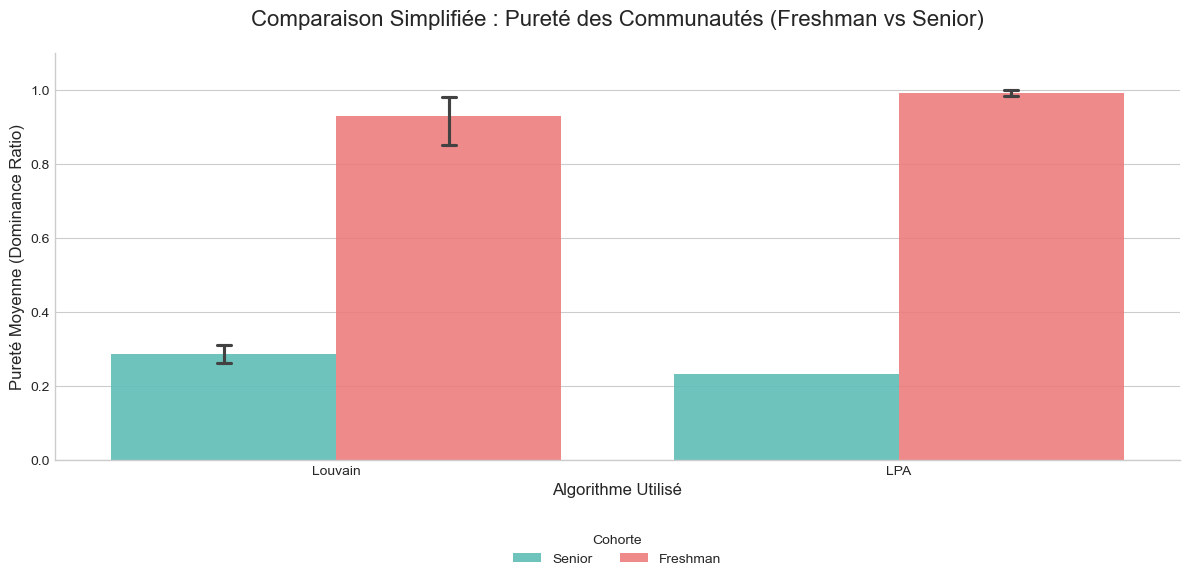

In [38]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=df[df['type'].isin(['Freshman', 'Senior'])],
    x='algorithm', 
    y='dominance_ratio', 
    hue='type',
    palette={'Freshman': '#FF6B6B', 'Senior': '#4ECDC4'},
    alpha=0.9,
    capsize=0.05,
)


plt.title("Comparaison Simplifiée : Pureté des Communautés (Freshman vs Senior)", fontsize=16, pad=20)
plt.ylabel("Pureté Moyenne (Dominance Ratio)", fontsize=12)
plt.xlabel("Algorithme Utilisé", fontsize=12)
plt.ylim(0, 1.1)
plt.legend(title='Cohorte', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)

sns.despine()

plt.tight_layout()
plt.savefig(path / 'comparaison_commu_age_q6.png', dpi=300)
plt.show()

Chargement de Caltech36...
Labels identifiés -> Freshman: 2009 | Senior: 2006


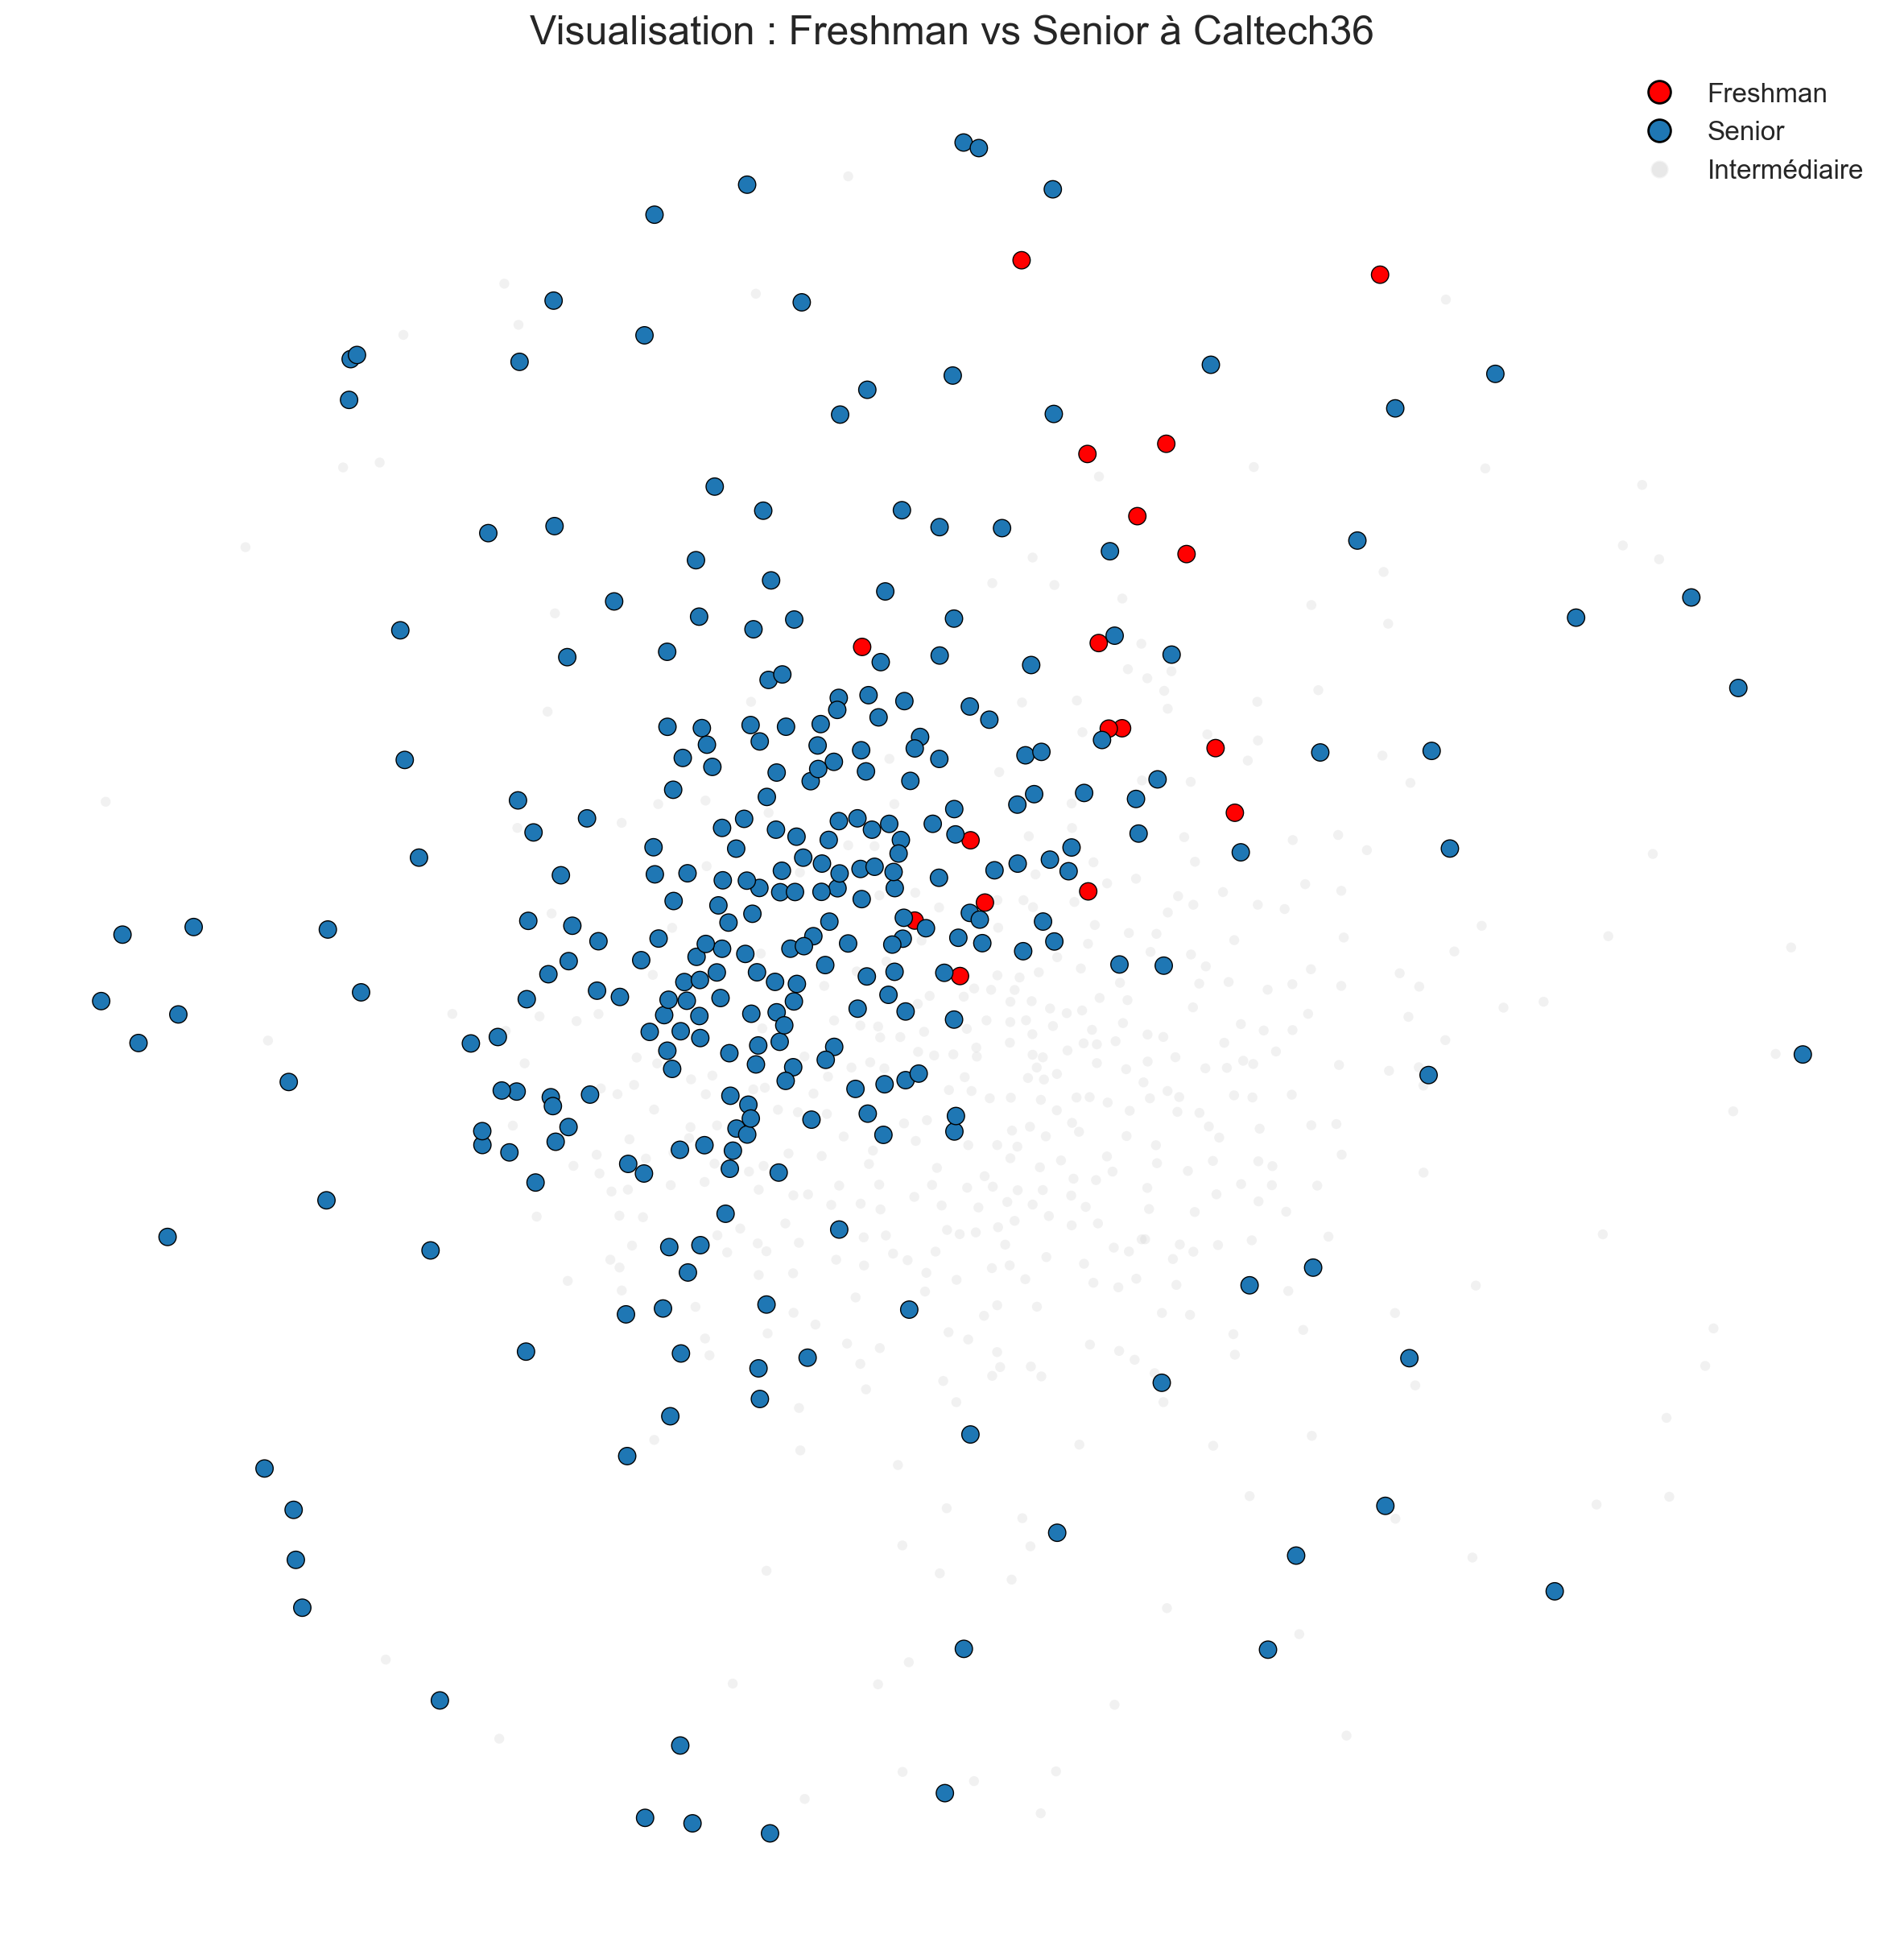

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

def get_cohort_targets(G):
    years = [G.nodes[n].get('year', 0) for n in G.nodes()]
    valid_years = [y for y in years if y >= 2004]
    
    if not valid_years: return None, None
    
    counts = Counter(valid_years)
    sorted_years = sorted(counts.keys(), reverse=True)
    fresh_candidate = sorted_years[0]
    
    if len(sorted_years) > 1:
        next_year = sorted_years[1]
        if counts[fresh_candidate] < 0.2 * counts[next_year]:
            fresh_target = next_year
        else:
            fresh_target = fresh_candidate
    else:
        fresh_target = fresh_candidate
        
    senior_target = fresh_target - 3 
    return fresh_target, senior_target

univ = 'Caltech36'
data_dir = Path("data")

print(f"Chargement de {univ}...")
G = nx.read_gml(data_dir / f"{univ}.gml")

largest_cc = max(nx.connected_components(G), key=len) #on garde que la LCC pour le graphe
G = G.subgraph(largest_cc).copy()

fresh_target, senior_target = get_cohort_targets(G)
print(f"Labels identifiés -> Freshman: {fresh_target} | Senior: {senior_target}")


communities = nx.community.louvain_communities(G, seed=42)

color_map = {
    'Freshman': '#ff0000',
    'Senior': '#1f77b4',
    'Intermediate': '#d3d3d3'
}

node_colors_dict = {}

for comm in communities:
    years = [G.nodes[n].get('year', 0) for n in comm]
    years = [y for y in years if y > 2000]
    
    c_type = 'Intermediate'
    
    if len(years) >= 5:
        counts = Counter(years)
        dom_year, _ = counts.most_common(1)[0]
        
        if dom_year == fresh_target:
            c_type = 'Freshman'
        elif dom_year == senior_target:
            c_type = 'Senior'
            
    this_color = color_map[c_type]
    for node in comm:
        node_colors_dict[node] = this_color

final_colors = [node_colors_dict.get(n, '#d3d3d3') for n in G.nodes()]


plt.figure(figsize=(15, 15), dpi=200)
pos = nx.spring_layout(G, k=0.7, iterations=100, seed=42) 

#on met les intermediate en gris dans le fond
nodes_gray = [n for n in G.nodes() if final_colors[list(G.nodes).index(n)] == '#d3d3d3']
nodes_highlight = [n for n in G.nodes() if n not in nodes_gray]
colors_gray = ['#d3d3d3'] * len(nodes_gray)
colors_highlight = [final_colors[list(G.nodes).index(n)] for n in nodes_highlight]

#on ne met pas les arêtes pour ne pas surcharger le graphe, la proximité suffit
nx.draw_networkx_nodes(
    G, pos, 
    nodelist=nodes_gray,
    node_color=colors_gray, 
    node_size=20,
    alpha=0.3,
    linewidths=0
)

nx.draw_networkx_nodes(
    G, pos, 
    nodelist=nodes_highlight,
    node_color=colors_highlight, 
    node_size=60,
    alpha=1.0,
    linewidths=0.5, 
    edgecolors='black'
)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['Freshman'], label=f'Freshman', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['Senior'], label=f'Senior', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#d3d3d3', label='Intermédiaire', markersize=8, alpha=0.5)
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.title(f"Visualisation : Freshman vs Senior à {univ}", fontsize=18)
plt.axis("off")
plt.show()

Chargement de Princeton12...
Labels identifiés -> Freshman: 2009 | Senior: 2006


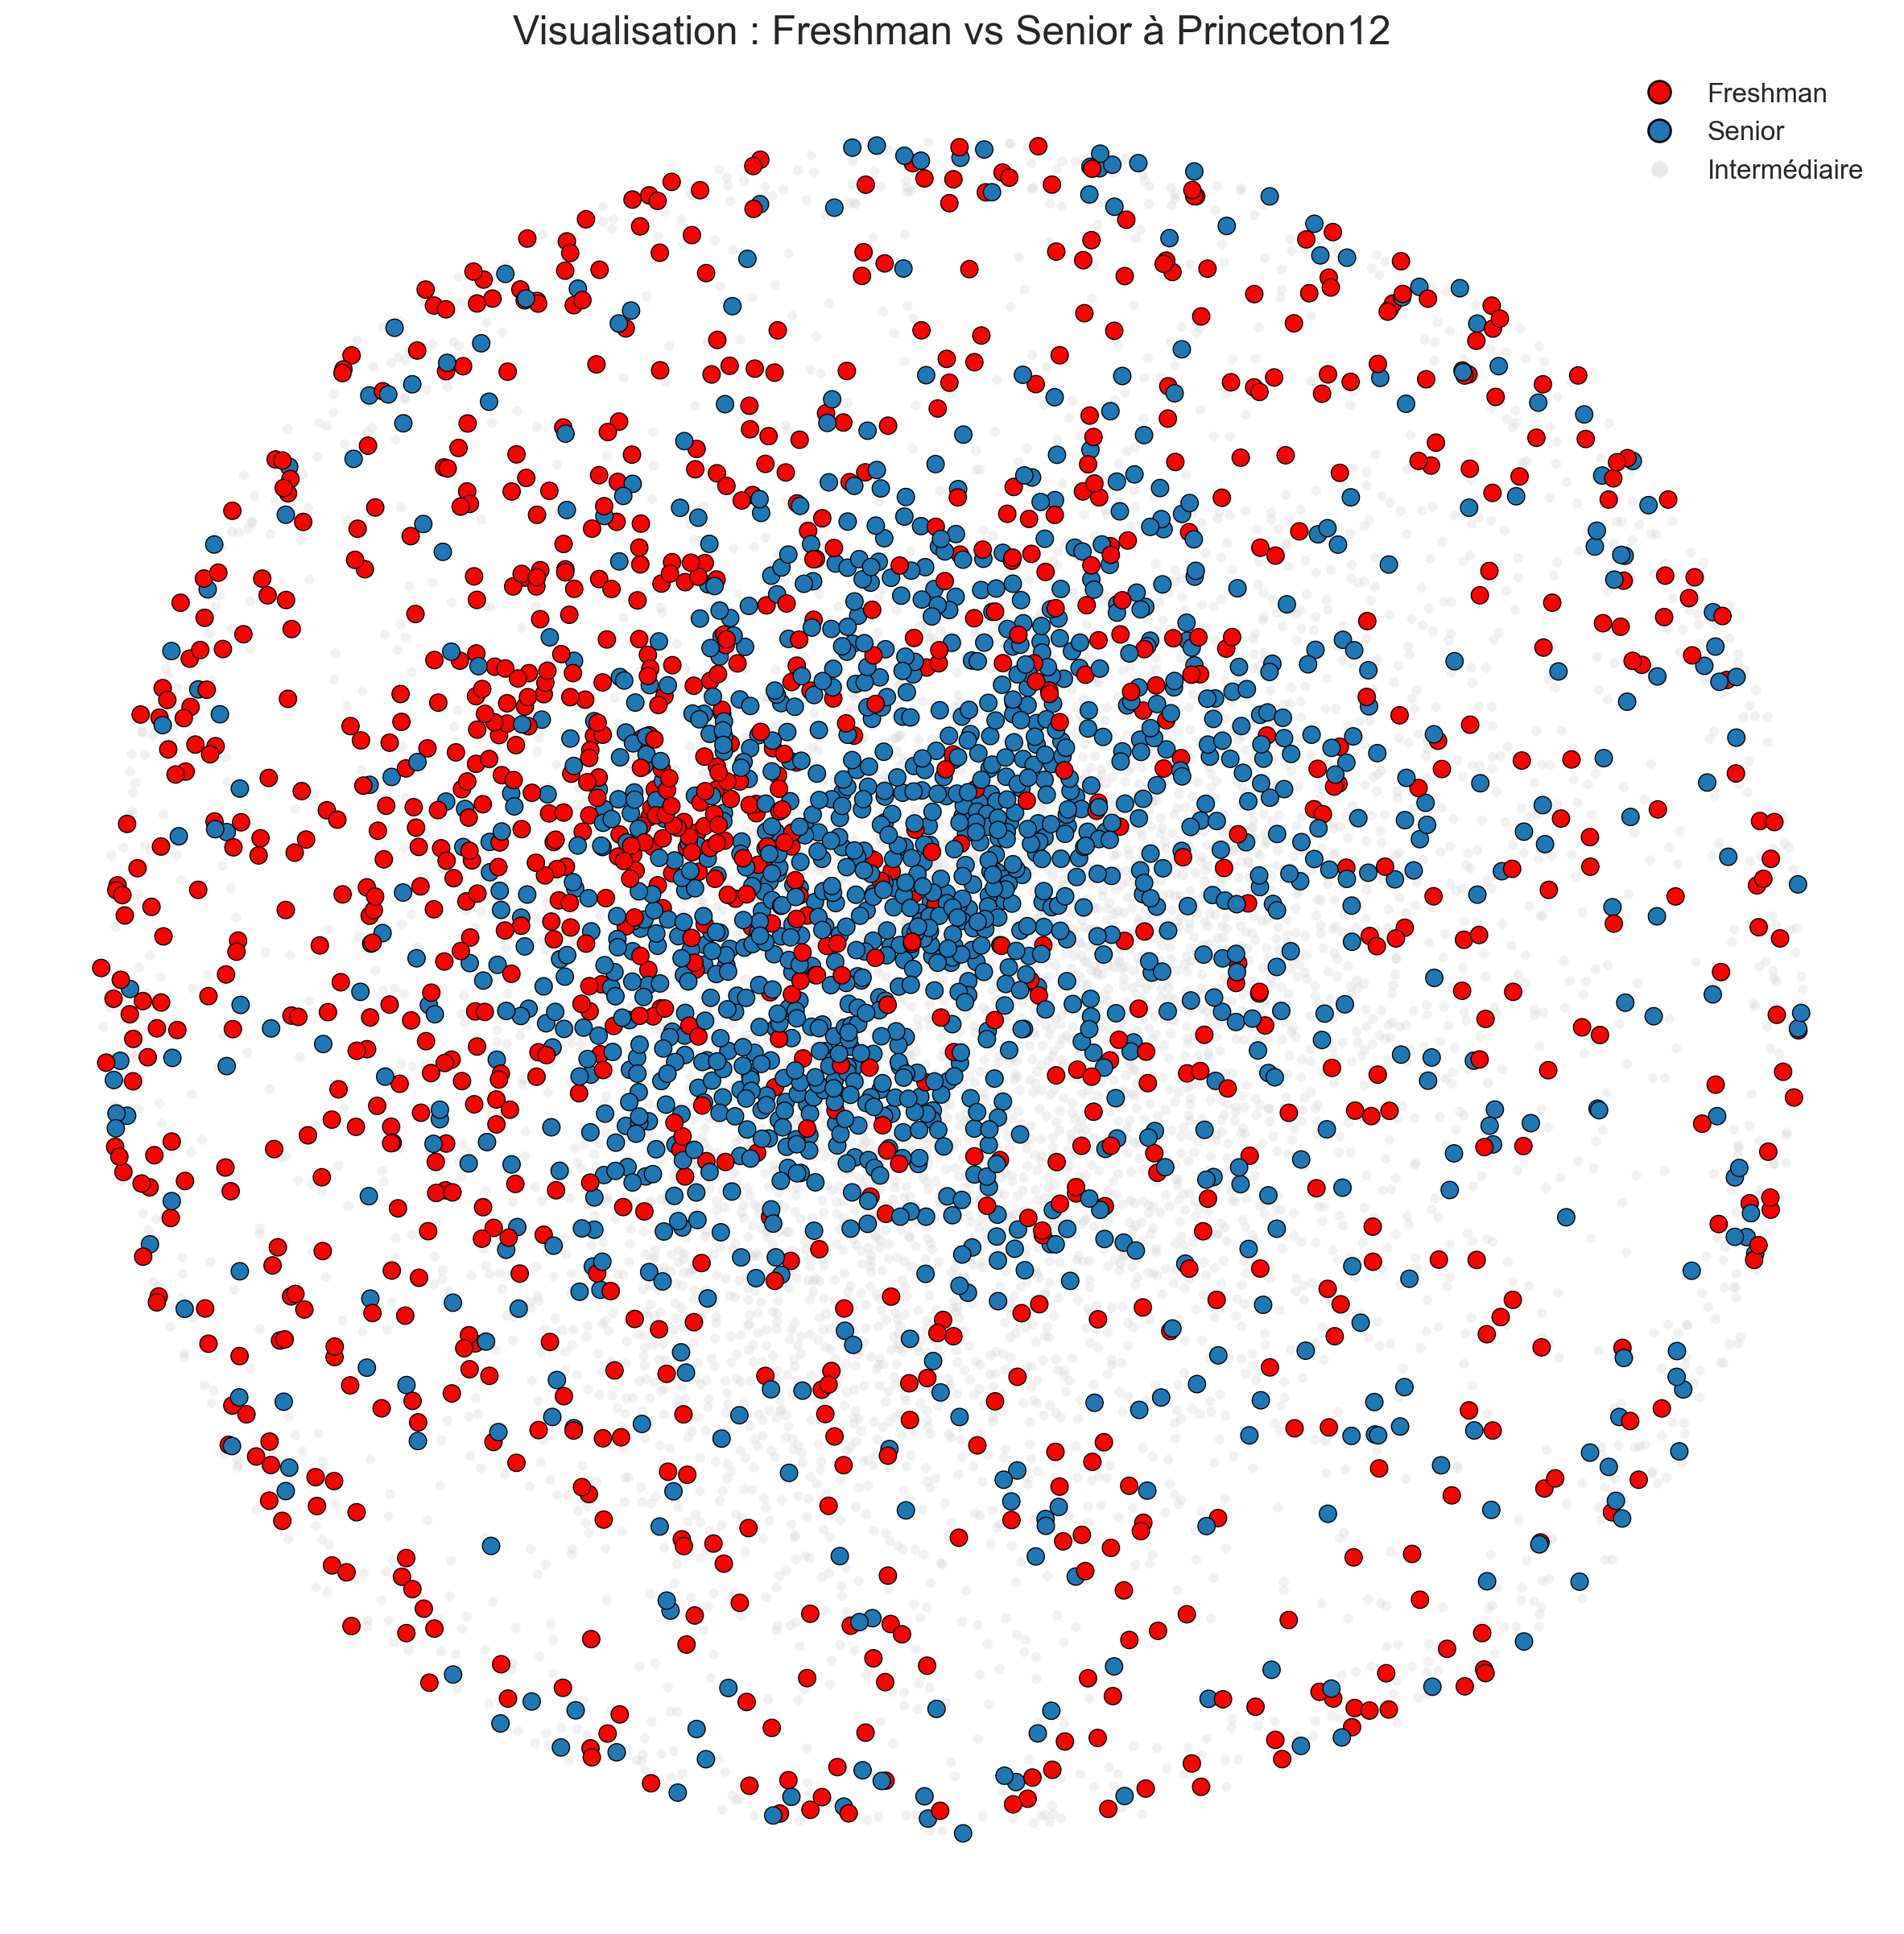

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

def get_cohort_targets(G):
    years = [G.nodes[n].get('year', 0) for n in G.nodes()]
    valid_years = [y for y in years if y >= 2004]
    
    if not valid_years: return None, None
    
    counts = Counter(valid_years)
    sorted_years = sorted(counts.keys(), reverse=True)
    fresh_candidate = sorted_years[0]
    
    if len(sorted_years) > 1:
        next_year = sorted_years[1]
        if counts[fresh_candidate] < 0.2 * counts[next_year]:
            fresh_target = next_year
        else:
            fresh_target = fresh_candidate
    else:
        fresh_target = fresh_candidate
        
    senior_target = fresh_target - 3 
    return fresh_target, senior_target

univ = 'Princeton12'
data_dir = Path("data")

print(f"Chargement de {univ}...")
G = nx.read_gml(data_dir / f"{univ}.gml")

largest_cc = max(nx.connected_components(G), key=len) #on garde que la LCC pour le graphe
G = G.subgraph(largest_cc).copy()

fresh_target, senior_target = get_cohort_targets(G)
print(f"Labels identifiés -> Freshman: {fresh_target} | Senior: {senior_target}")


communities = nx.community.louvain_communities(G, seed=42)

color_map = {
    'Freshman': '#ff0000',
    'Senior': '#1f77b4',
    'Intermediate': '#d3d3d3'
}

node_colors_dict = {}

for comm in communities:
    years = [G.nodes[n].get('year', 0) for n in comm]
    years = [y for y in years if y > 2000]
    
    c_type = 'Intermediate'
    
    if len(years) >= 5:
        counts = Counter(years)
        dom_year, _ = counts.most_common(1)[0]
        
        if dom_year == fresh_target:
            c_type = 'Freshman'
        elif dom_year == senior_target:
            c_type = 'Senior'
            
    this_color = color_map[c_type]
    for node in comm:
        node_colors_dict[node] = this_color

final_colors = [node_colors_dict.get(n, '#d3d3d3') for n in G.nodes()]


plt.figure(figsize=(15, 15), dpi=200)
pos = nx.spring_layout(G, k=0.7, iterations=100, seed=42) 

#on met les intermediate en gris dans le fond
nodes_gray = [n for n in G.nodes() if final_colors[list(G.nodes).index(n)] == '#d3d3d3']
nodes_highlight = [n for n in G.nodes() if n not in nodes_gray]
colors_gray = ['#d3d3d3'] * len(nodes_gray)
colors_highlight = [final_colors[list(G.nodes).index(n)] for n in nodes_highlight]

#on ne met pas les arêtes pour ne pas surcharger le graphe, la proximité suffit
nx.draw_networkx_nodes(
    G, pos, 
    nodelist=nodes_gray,
    node_color=colors_gray, 
    node_size=20,
    alpha=0.3,
    linewidths=0
)

nx.draw_networkx_nodes(
    G, pos, 
    nodelist=nodes_highlight,
    node_color=colors_highlight, 
    node_size=60,
    alpha=1.0,
    linewidths=0.5, 
    edgecolors='black'
)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['Freshman'], label=f'Freshman', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['Senior'], label=f'Senior', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#d3d3d3', label='Intermédiaire', markersize=8, alpha=0.5)
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.title(f"Visualisation : Freshman vs Senior à {univ}", fontsize=18)
plt.axis("off")
plt.show()